# Project 2: Segmentation

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Setting up PyMaxFlow: <span style="color:red;">30-60min</span>
* 2. Getting your first successful segmentation: <span style="color:red;">10hrs</span>
* 3. Adjusting parameters (e.g. $\lambda$, $\sigma$) and so forth, to get good results: <span style="color:red;">30-60min</span>
* 4. Completing the write-up: <span style="color:red;">15min</span>

Note that there are two folders within the project.  We have provided some images for you to use in testing your implementation, in the `provided images` folder along with their ground-truth segmentations to compare your results to.  Along with these, we want you to provide 2-4 additional images that you select on which you show your results.  <i>Please use the `provided_images` in that path and place any others in the `user_data` folder, and load all of the images (or user input point location files) via the approapriate relative path.  We will drop your notebook file and your `user_data` folder into our folder (which will have the `provided_images` already) and then run your notebook.</i>




## Preparation:
So that you can focus on the elements of the cost function ( the link weights), you may use a existing implementation of the actual min-cut algorithm itself.  You set up the graph, but it will take care of finding the minimum cut.

For this assignment we will be using a python library called PyMaxFlow.  This library is a python wrapper around the original C++ implementation of the min-cut code from [Vladimir Kolmogorov](http://pub.ist.ac.at/%7Evnk/software.html) (who has co-authored several papers on this subject).    

Note: For windows users, you will need the Visual C++ compiler in order for PyMaxFlow to work.  If you already have Visual Studio, this shouldn't be a problem but if you just want the compiler without Visual Studio, you can download [Build Tools For Visual Studio 2017](https://visualstudio.microsoft.com/downloads/#build-tools-for-visual-studio-2017). Once you have access to the Visual C++ compiler look at the next paragraph for PyMaxFlow installation.

PyMaxFlow requires Cython, which should come standard in your anaconda environment but the command to install that will also be included.  To install PyMaxFlow enter the following commands replacing "YourEnvironmentName" with the name of your anaconda environment.
~~~
conda activate YourEnvironemntName
conda install cython
pip install pymaxflow
~~~
Once PyMaxFlow is installed, to understand how to use the library, there is a great [tutorial page](http://pmneila.github.io/PyMaxflow/tutorial.html) that shows how to get started with some simple examples.  Do the "first example" and perhaps the "binary image restoration" as well.

In [93]:
import maxflow
import math
import numpy as np
from sklearn.neighbors import KernelDensity



## Annotations:
Graph cut segmentation is an interactive algorithm requiring the user to provide foreground and background seeds.  Provided is a python file that will open a gui and allow you to annotate the image.  This gui is optional and will require additional packages to be installed into your environment.  To install the packages open a terminal and enter the following commands:
~~~
conda activate YourEnvironmentName
conda install scikit-image pillow
~~~
You can use the gui in the following way:
```python
import guiseg
fore, back = guiseg.get_fore_back(image)
image[fore]  # the foreground seeds
image[back]  # the background seeds
```

For the `guiseg` routine to run, I also found it necssary to install PIL ImageTk (For me, it was `sudo apt install python3-pil.imagetk` but it will be different for Conda).

In [125]:
import guiseg
import cv2

BANANA = "banana"
LLAMA = "llama"
PENGUIN = "penguin"
SIMPLE_CIRCLE = "simplecircle"
TEDDY = "teddy"
SQUISH_EASY = "squish"
CAMELEON_HARD = "cameleon"

def read_image(name, is_provided=True):
    imageBGR = cv2.imread(f'{"provided_images" if is_provided else "user_data"}/{name}.{"jpg" if name in [LLAMA] else "png"}');
    image = imageBGR[:,:,::-1]; # I reverse the BGR from OpenCV to BGR

    # When the GUI pops up, you can pick either the "Foreground" or "Background" buttons to
    # select pixels to be respective seeds.  Once you're finished, click "Return"
#     fore, back = guiseg.get_fore_back(image)
#     with open(f"user_data/dimen_f_{name}.txt", "w") as f: 
#         for row in fore:
#             np.savetxt(f, row)
#     with open(f"user_data/dimen_b_{name}.txt", "w") as f: 
#         for row in back:
#             np.savetxt(f, row)

    dimen_f_raw = np.loadtxt(f"user_data/dimen_f_{name}.txt")
    dimen_f = tuple(np.array(dimen_f_raw.reshape(2, int(len(dimen_f_raw)/2)), dtype=np.int32))
    dimen_b_raw = np.loadtxt(f"user_data/dimen_b_{name}.txt")
    dimen_b = tuple(np.array(dimen_b_raw.reshape(2, int(len(dimen_b_raw)/2)), dtype=np.int32))
    
    return image, dimen_f, dimen_b




## Graph Cut:
Your code should read in an image and a set of seed pixels and use graph-cut segmentation to segment the image.

You will need to calculate the costs for the t-links (region terms) and the n-links (boundary terms). See the book, the notes/slides, or published papers in this area for ideas of how to define these.  Remember that the t-link weights to a particular terminal (foreground or background) should be large if that pixel looks a lot like the respective foreground/background seeds. The n-link weights should be large if the two neighboring pixels are similar.

Here is [the original paper on graph-cut segmentation](http://www.csd.uwo.ca/~yuri/Papers/iccv01.pdf), which might help with some ideas, but you should look at the literature to see what other costs functions / link weights others have used.

Once the graph is built, use the min-cut algorithm to partition the graph into nodes connected to the foreground node or to the background node, then use these as the resulting labels for the segmentation. Display this result graphically in some fashion overlaid on the input image.  It is best to start with simple images whose foreground and background colors are pretty different and for ones where the edges are pretty clear.  Graph-cut segmentation struggles sometimes with long, thin structures, so you should avoid these types of images early on.



In [126]:
# Implementation Here (feel free to add additional cells of course)
def boundary_func(pixel1, pixel2, sigma=3):
    return np.exp(np.linalg.norm(np.square(pixel1 - pixel2))/(-2*math.pow(sigma, 2)))

def get_tri_map(image, fore, back):
    shape = image.shape
    rows, cols = shape[0], shape[1]
    
    tri_map = np.full(shape, 180)
    tri_map[fore] = 255
    tri_map[back] = 0
    return tri_map

def get_result_images(image, dimen_f, dimen_b, lambda_arg=3):
    shape = image.shape
    rows, cols = shape[0], shape[1]
    
    g = maxflow.Graph[int](shape[0]*shape[1], (shape[0]-1)*(shape[1]-1))
    nodes = g.add_nodes(shape[0]*shape[1])
    
    kde_fore = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(image[dimen_f])
    kde_back = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(image[dimen_b])
    
    for row in range(rows-1):
        for col in range(cols-1):
            # n-links
            weight_row = boundary_func(image[row,col], image[row+1, col])
            weight_col = boundary_func(image[row,col], image[row, col+1])
            g.add_edge(nodes[row*cols + col], nodes[row*cols + col + 1], weight_row, weight_row)
            g.add_edge(nodes[row*cols + col], nodes[(row+1)*cols + col + 1], weight_row, weight_col)
    print("Generating n-links 100%")

    for row in range(rows):
        for col in range(cols):
            # t-links
            weight_fore = lambda_arg * kde_fore.score([image[row,col]])
            weight_back = lambda_arg * kde_back.score([image[row,col]])
            g.add_tedge(nodes[row*cols + col], weight_fore, weight_back)
    print("Generating t-links 100%")

    flow = g.maxflow()

    dcopy = image.copy()
    for row in range(rows):
        for col in range(cols):
            if g.get_segment(nodes[row*cols + col]) == 1:
                dcopy[row,col] = 0
            
    return image, get_tri_map(image, dimen_f, dimen_b), dcopy

In [127]:
# Generate results Here (again, add additional cells to your heart's content)
import matplotlib.pyplot as plt

def show_results(original, tri_map, segmented):
    imgplot = plt.imshow(original)
    plt.title("Original Image")
    plt.show(imgplot)

    imgplot = plt.imshow(tri_map)
    plt.title("Tri-Map")
    plt.show(imgplot)

    imgplot = plt.imshow(segmented)
    plt.title("Segmented Image")
    plt.show(imgplot)

Generating n-links 100%
Generating t-links 100%


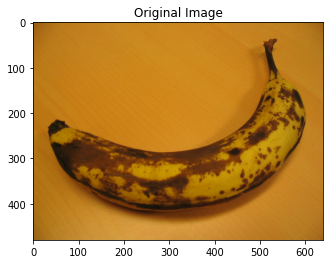

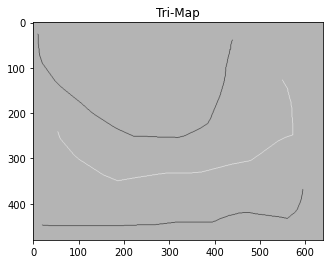

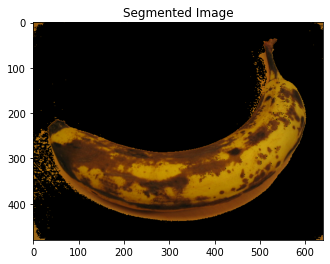

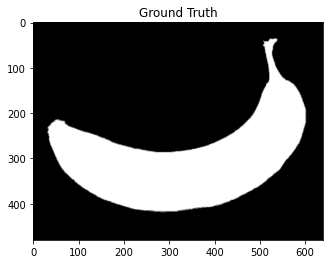

Generating n-links 100%
Generating t-links 100%


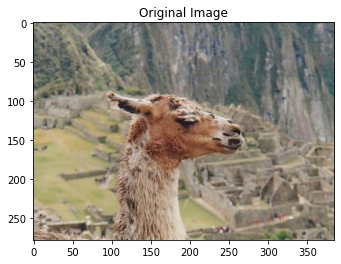

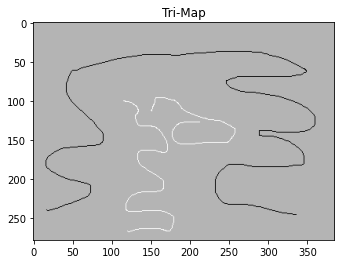

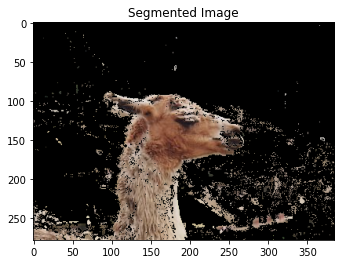

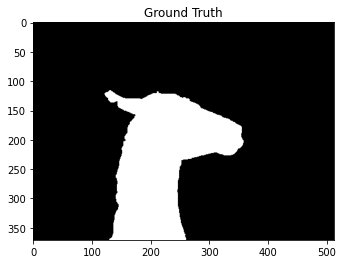

Generating n-links 100%
Generating t-links 100%


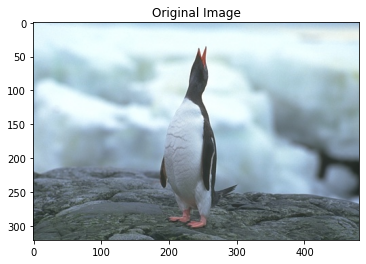

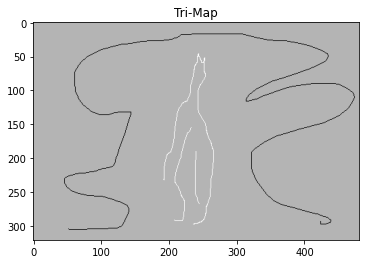

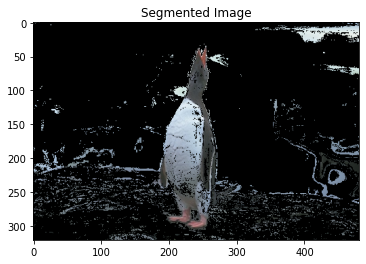

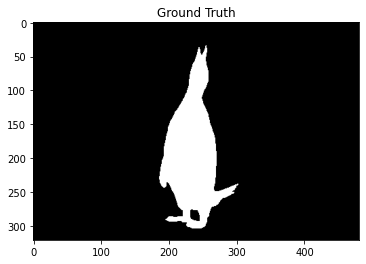

Generating n-links 100%
Generating t-links 100%


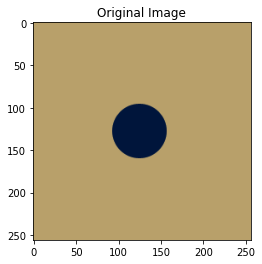

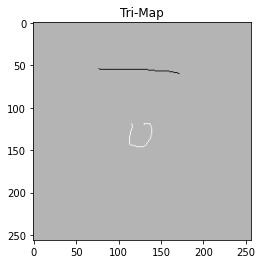

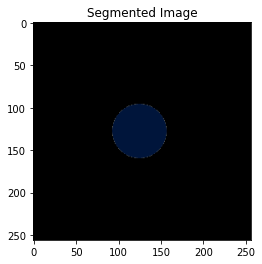

Generating n-links 100%
Generating t-links 100%


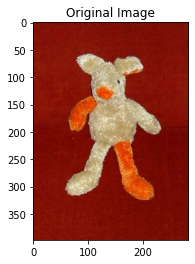

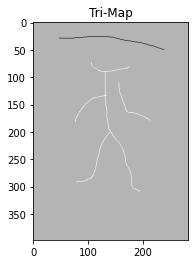

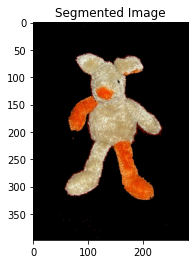

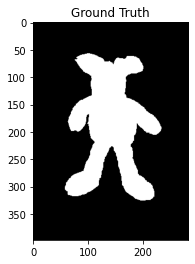

Generating n-links 100%
Generating t-links 100%


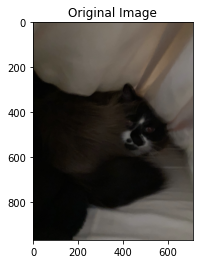

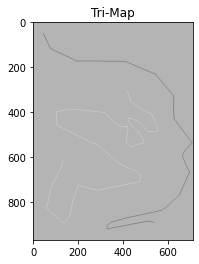

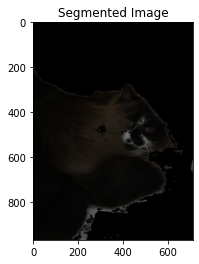

Generating n-links 100%


In [ ]:
# Script to do entire process in a single image
def segment_image(name, is_provided=True):
    image, dimen_f, dimen_b = read_image(name, is_provided)
    original, tri_map, segmented = get_result_images(image, dimen_f, dimen_b)
    show_results(original, tri_map, segmented)
    # Forgot to show the ground truth, so this is a guetto fix
    if is_provided and name != SIMPLE_CIRCLE:
        gt_raw = cv2.imread(f'provided_images/ground_truth/{name}-seg.png');
        gt = gt_raw[:,:,::-1]; # I reverse the BGR from OpenCV to BGR
        gtplot = plt.imshow(gt)
        plt.title("Ground Truth")
        plt.show(gtplot)

# Script to do entire process for all images
for img in [BANANA, LLAMA, PENGUIN, SIMPLE_CIRCLE, TEDDY]:
    segment_image(img)
    
for img in [SQUISH_EASY, CAMELEON_HARD]:
    segment_image(img, is_provided=False)    



## Grading / Rubric
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly generates the graph network structure (nodes, n-links, t-links).
* [10 pts] Code that produces the boundary term $B(p,q)$ used for n-links.
* [10 pts] Code that produces the region term of the cost $R(p,A)$ used for the t-links.  Remember that you have t-links per pixel, one with cost determined by matching $p$ with the foreground appearance distribution, the other determined relative to the background distribution.  You may use the [sk-learn implementation](https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation) of Kernel Density Estimation.  However you will receive 10 extra points if you implement it yourself.
* [20 pts] Implementing the graph-cut with `pymaxflow` and finding the optimal solution for the input graph.
* [10 pts] Displaying Results in the following format (for each input image you'll show the following 3-4 result images):
   1. Original Image.
   2. Tri-map of what was selected by the user (white for foreground, black for background, gray for unknown).  This can be overlaid on top of a faint copy of the image for context if desired.
   3. Final segmentation.  Again you can overlay it on a faint copy of the original for context.
   4. On the <i>provided images</i> please show a comparison of your resulting segmentaiton with the ground truth.
* [20 pts] Good (certainly not perfect, some of them are challenging, but decent/reasonable) results on the 4 provided images (banana, llama, penguin, teddy).  Each image will receive up to 5 points.
* [10 pts] Demonstrating your algorithm on 2-4 additional images.  At least one of the images should be somewhat easy, one should be somewhat challenging -- expalin why you think they're respectively easy/challenging.


## Write-up:
Provide an explanation for the following items:
* Describe how you determinied/computed the n-link and t-link weights.
* What kinds of image does graph cut segmentation work well for? What kinds of images do you find it struggles with?
* What did you learn from the project?
* What if any suggestions do you have for improving it (for future students)?

<span style="color:red;">
I computed the n-link and the t-link weights using the formula in the slides. An NxN image will have an edge 2D array of (N-1)x(N-1), so I was able to assign the n-links based on the node's coordinates. I computed the t-link using the sk-learn implementation of Kernel Density estimation and getting the log-likelihood of each pixel being part of each region, times the lambda of course.
The graph cut segmentation algorithm I implemented works well for images with a clear color distinction between foreground and background. When the color scheme was very uniform my results tend to be worse. I first noticed this with my llama, which at first was an absolute mess. Because of this I chose a cameleon as my own hard image, because it can camouflage which I suspected would make my algorithm go nuts.
I learned how to compute n-links and t-links and how those are used together to generate a cut in the graph splitting foreground and background. I also learned some of the libraries used in this lab which I was not familiar with before. It took a lot of reading documentation to know how to create my graph in pymaxflow, but once I had it the library took care of the heavy work for us.
I think I learned a lot because I struggled a lot. Truth is there really weren't a lot of resources for us to use. We have class and the slides, but the slides don't really have a lot of information or examples. Examples of the computation happening in the slides would have been extremely helpful. When it came to online resources there wasn't much as well. I'm not sure if that's because computer vision is maybe a newer field and so the literature isn't as organized or sorted well enough for a beginner like myself to use. Other than that it was a fun lab. Felt rewarding when I finally had it going. 
</span>